<a href="https://colab.research.google.com/github/Wonhochoi123/Skin_Cancer_Detection_-Final_Project-/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 18 07:30:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

import shutil

shutil.copy('/content/gdrive/MyDrive/Dataset2.zip','/content/Dataset2.zip')



'/content/Dataset2.zip'

In [ ]:
# Navigate to the copied file and unzip it quietly
!unzip -q '/content/Dataset2.zip'

classes_train/BKL/ISIC_0063993.jpg  bad CRC 190d73bb  (should be 97b29ea1)
classes_train/BKL/ISIC_0072343.jpg  bad CRC f577bf6b  (should be 76429ba7)
classes_train/BKL/ISIC_0072421.jpg  bad CRC 2a828e7d  (should be 2240415f)
classes_train/MEL/ISIC_0032396.jpg  bad CRC 1397f0c9  (should be b0c49090)
classes_train/MEL/ISIC_0053960.jpg  bad CRC 02e8a7a4  (should be 3a50f216)
classes_train/MEL/ISIC_0057044.jpg  bad CRC cf9c2ae4  (should be 3bd4fcaa)
classes_train/MEL/ISIC_0057048.jpg  bad CRC fb2fb66c  (should be 409e0d3a)
classes_train/MEL/ISIC_0061049.jpg  bad CRC 08f30e5c  (should be ed58c0ff)
classes_train/NV/ISIC_0025028.jpg  bad CRC a73ceb4b  (should be 3bcc4e54)
classes_train/NV/ISIC_0025042.jpg  bad CRC b18fb418  (should be 0308d4c0)
classes_train/NV/ISIC_0025406.jpg  bad CRC e2c13866  (should be 2fefaa14)
classes_train/NV/ISIC_0027530.jpg  bad CRC 83d26a31  (should be 659b5124)
classes_train/NV/ISIC_0027547.jpg  bad CRC 297c247c  (should be 6589dc32)
classes_train/NV/ISIC_0030049.

In [ ]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-50,50 )
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
        return image_array[:, ::-1]

In [ ]:


def oversample(target_num_image):
    import random
    import os
    import skimage.io
    import glob


    for j in ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']:
        # our folder path containing some images
        folder_path = "/content/classes_train/"+j
        # the number of file to generate
        num_files_desired = target_num_image-len(glob.glob("/content/classes_train/"+j+"/*.jpg"))

        # loop on all files of the folder and build a list of files paths
        images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        num_generated_files = 0
        while num_generated_files <= num_files_desired:
            # random image from the folder
            image_path = random.choice(images)
            # read image as an two dimensional array of pixels
            image_to_transform = skimage.io.imread(image_path)
            num_generated_files = num_generated_files+1
            # dictionary of the transformations functions we defined earlier
            available_transformations = {
                'rotate': random_rotation,
                'noise': random_noise,
                'horizontal_flip': horizontal_flip
            }

            # random num of transformations to apply
            num_transformations_to_apply = random.randint(1, len(available_transformations))

            num_transformations = 0
            transformed_image = None
            while num_transformations <= num_transformations_to_apply:
                # choose a random transformation to apply for a single image
                key = random.choice(list(available_transformations))
                transformed_image = available_transformations[key](image_to_transform)
                num_transformations += 1



                # define a name for our new file
                new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

                # write image to the disk
                skimage.io.imsave(new_file_path, transformed_image)
                print(num_generated_files,'/',num_files_desired,num_transformations,j)




In [ ]:
oversample(2500)

1993 / 1998 3 SCC
1993 / 1998 4 SCC
1994 / 1998 1 SCC


1994 / 1998 2 SCC
1994 / 1998 3 SCC
1995 / 1998 1 SCC
1995 /

 1998 2 SCC
1995 / 1998 3 SCC


1995 / 1998 4 SCC
1996 / 1998 1 SCC
1996 / 1998 2 SCC


1996 / 1998 3 SCC
1996 / 1998 4 SCC


1997 / 1998 1 SCC
1997 / 1998 2 SCC
1997 / 1998 3 SCC


1997 / 1998 4 SCC
1998 / 1998 1 SCC
1998 / 1998 2 SCC
1998 / 1998 3 SCC


1999 / 1998 1 SCC


1999 / 1998 2 SCC


1999 / 1998 3 SCC
1999 / 1998 4 SCC


In [ ]:
def removing_machine(final_amount):
  import shutil
  import numpy as np
  from sklearn.model_selection import train_test_split
    
  for c in ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']:
        
    for m in random.sample(glob.glob("/content/classes_train/"+c+"/*.jpg"),   len(glob.glob("/content/classes_train/"+c+"/*.jpg"))-final_amount) :
            

      shutil.move(m,'/content/Untitled Folder/'+c+"/*.jpg")
    

In [ ]:
removing_machine(2500)

In [ ]:
import glob
labels_dict={}
for i in training_set.class_indices:

  labels_dict[training_set.class_indices[str(i)]]=len(glob.glob("/content/classes_train/"+i+"/*.jpg"))

In [ ]:
labels_dict

{0: 2500, 1: 2500, 2: 2500, 3: 2500, 4: 2500, 5: 2500, 6: 2500, 7: 2500}

In [ ]:
import shutil
shutil.move('/content/classes_test/','/content/Dataset3/classes_test/')

shutil.move('/content/classes_train/','/content/Dataset3/classes_train/')


'/content/Dataset3/classes_train/'

In [ ]:
! zip -r '/content/Dataset3.zip' '/content/Dataset3/'

In [ ]:

import shutil

shutil.copy('/content/Dataset3.zip','/content/gdrive/MyDrive/Dataset3.zip')

'/content/gdrive/MyDrive/Dataset3.zip'

# **Sart from here now**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:

import shutil

shutil.copy('/content/gdrive/MyDrive/Dataset3.zip','/content/Dataset3.zip')



'/content/Dataset3.zip'

In [4]:
# Navigate to the copied file and unzip it quietly
!unzip -q '/content/Dataset3.zip'

In [5]:
#Let's start with importing most of the modules to use to begin with
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
import keras.utils # convert to one-hot-encoding

import tensorflow as tf
from sklearn.utils import class_weight

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt 

In [6]:

#let's set up how we would train the model
S=224

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_set = train_datagen.flow_from_directory('/content/content/Dataset3/classes_train',
                                                 target_size = (S,S),
                                                #  batch_size = 128,
                                                 class_mode = 'categorical')


testing_set = test_datagen.flow_from_directory('/content/content/Dataset3/classes_test',
                                               target_size = (S,S),
                                              #  batch_size = 128,
                                               shuffle=False,
                                               class_mode = 'categorical')

Found 20000 images belonging to 8 classes.
Found 5069 images belonging to 8 classes.


In [113]:

#This is how the classes coded
training_set.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [8]:
# In order to make class_weight dictionary, I'm making a dict of class:count
import glob
labels_dict={}
for i in training_set.class_indices:

  labels_dict[training_set.class_indices[str(i)]]=len(glob.glob("/content/content/Dataset3/classes_train/"+i+"/*.jpg"))


In [9]:
# It's a very imbalanced data! We better weigh differenty by class
labels_dict

{0: 2500, 1: 2500, 2: 2500, 3: 2500, 4: 2500, 5: 2500, 6: 2500, 7: 2500}

In [10]:
import numpy as np
import math
# formula for class_weight

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    
    for key in keys:
        score = (mu*total/(2*float(labels_dict[key])))
        class_weight[key] = score 
    
    return class_weight

In [11]:
class_weight=create_class_weight(labels_dict)

In [12]:
class_weight

{0: 0.6, 1: 0.6, 2: 0.6, 3: 0.6, 4: 0.6, 5: 0.6, 6: 0.6, 7: 0.6}

In [13]:

# weighing more for dangerouse leigion. so we boost true positives for those 
# dangerous:ak,bcc,mel,scc
def weight_change(mul):
  for i in [0,1,4,6]:
    class_weight[i]=class_weight[i]*mul*2
  for k in [2,3,5,7]:
    class_weight[k]=class_weight[k]/mul*2
    

In [14]:
weight_change(1.4)
class_weight

{0: 1.68,
 1: 1.68,
 2: 0.8571428571428572,
 3: 0.8571428571428572,
 4: 1.68,
 5: 0.8571428571428572,
 6: 1.68,
 7: 0.8571428571428572}

In [15]:
#setting the base model
resent_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=[S,S,3])
#for layer in resent_model.layers:
#    layer.trainable = False

94674944/94668760 [==============================] - 2s 0us/step


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

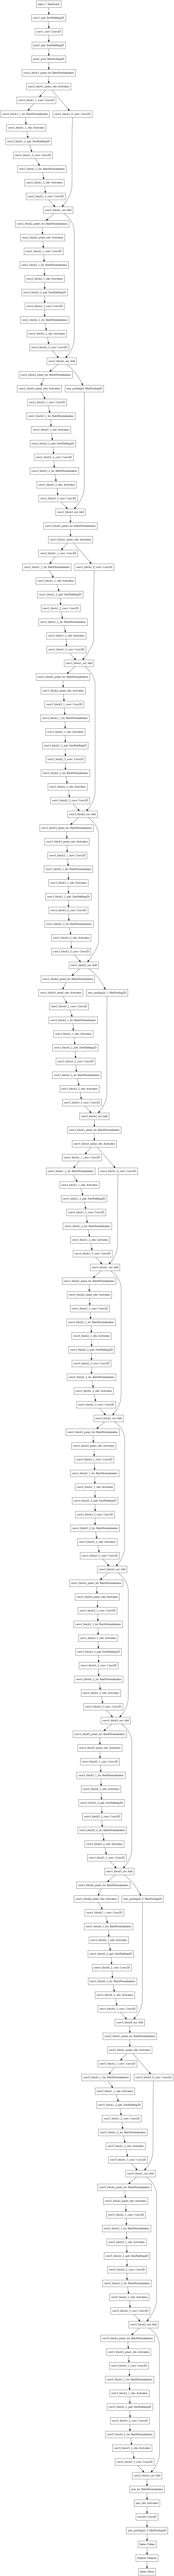

In [16]:
# A little bit of customization
from keras import regularizers
from keras.layers import Dropout

l2 = regularizers.l2(0.20)

x = Conv2D(128, (3, 3), activation='relu')(resent_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.5)(x)
x = Flatten()(x)


# x = Dense(64,activation='relu')(x)
x=Dropout(0.82)(x)

x = Dense(8,activation='softmax', kernel_regularizer=l2)(x)

model = Model(inputs=resent_model.input, outputs=x)
# opt = keras.optimizers.Adam(learning_rate=3e-4*30) ended up not using it     keras.optimizers.Adam(lr=0.001, decay=1e-6)#regularization to prevent overfitting
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=(3e-4)/40), 
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
print(model.summary())
keras.utils.plot_model(model)


In [24]:
import pickle

In [26]:
    with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

# **START**

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

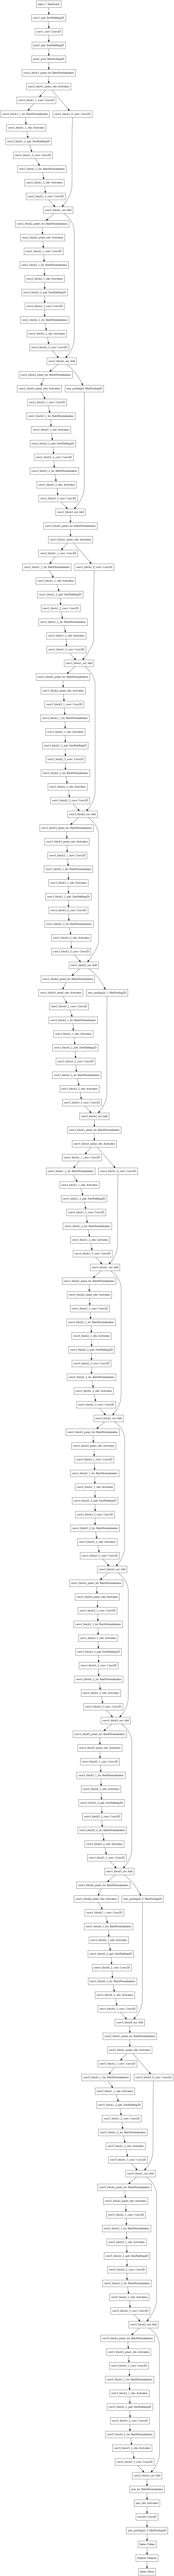

In [31]:
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=(3e-4)/8), 
#     loss='categorical_crossentropy',
#     metrics = ['accuracy']
# )
# print(model.summary())
# keras.utils.plot_model(model)


In [32]:
from keras.callbacks import ReduceLROnPlateau

In [34]:
# model=keras.models.load_model('/content/model_final355.h5')

In [39]:
#And now we are fitting the model.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.01)
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs =20,class_weight=class_weight)

Epoch 1/20
625/625 [==============================] - 558s 893ms/step - loss: 0.1483 - accuracy: 0.9955 - val_loss: 1.9202 - val_accuracy: 0.7532
Epoch 2/20
625/625 [==============================] - 549s 878ms/step - loss: 0.1330 - accuracy: 0.9948 - val_loss: 1.7878 - val_accuracy: 0.7666
Epoch 3/20
625/625 [==============================] - 547s 875ms/step - loss: 0.1204 - accuracy: 0.9954 - val_loss: 1.7693 - val_accuracy: 0.7741
Epoch 4/20
 52/625 [=>............................] - ETA: 7:09 - loss: 0.1096 - accuracy: 0.9958

KeyboardInterrupt: ignored

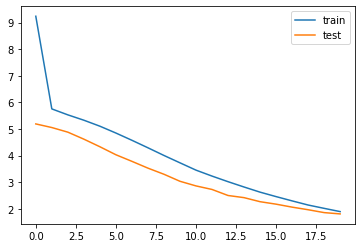

In [19]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

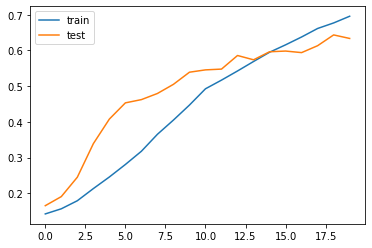

In [20]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [40]:

from tensorflow.keras.models import load_model

from google.colab import files

model.save('model_final_abs.h5')

files.download('model_final_abs.h5') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
hist

In [ ]:
# predict proba

In [41]:
from sklearn.metrics import accuracy_score
predict=model.predict(testing_set)
y_pred = np.argmax(predict, axis=1)
accuracy_score(testing_set.labels,y_pred)



0.768396133359637

In [122]:
from sklearn.metrics import confusion_matrix

y_true=testing_set.labels
mult_c=confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])



In [109]:
mult_c

array([[ 112,   26,   23,    0,    8,    0,    5,    0],
       [  13,  598,   19,    0,   13,   15,    6,    1],
       [   6,   30,  407,    0,   37,   42,    3,    0],
       [   0,    6,    1,   35,    0,    6,    0,    0],
       [   3,   18,   85,    1,  675,  119,    3,    1],
       [   6,   82,  195,    3,  332, 1942,    5,   10],
       [   3,   13,   13,    0,    8,    3,   86,    0],
       [   0,    4,    1,    0,    3,    2,    1,   40]])

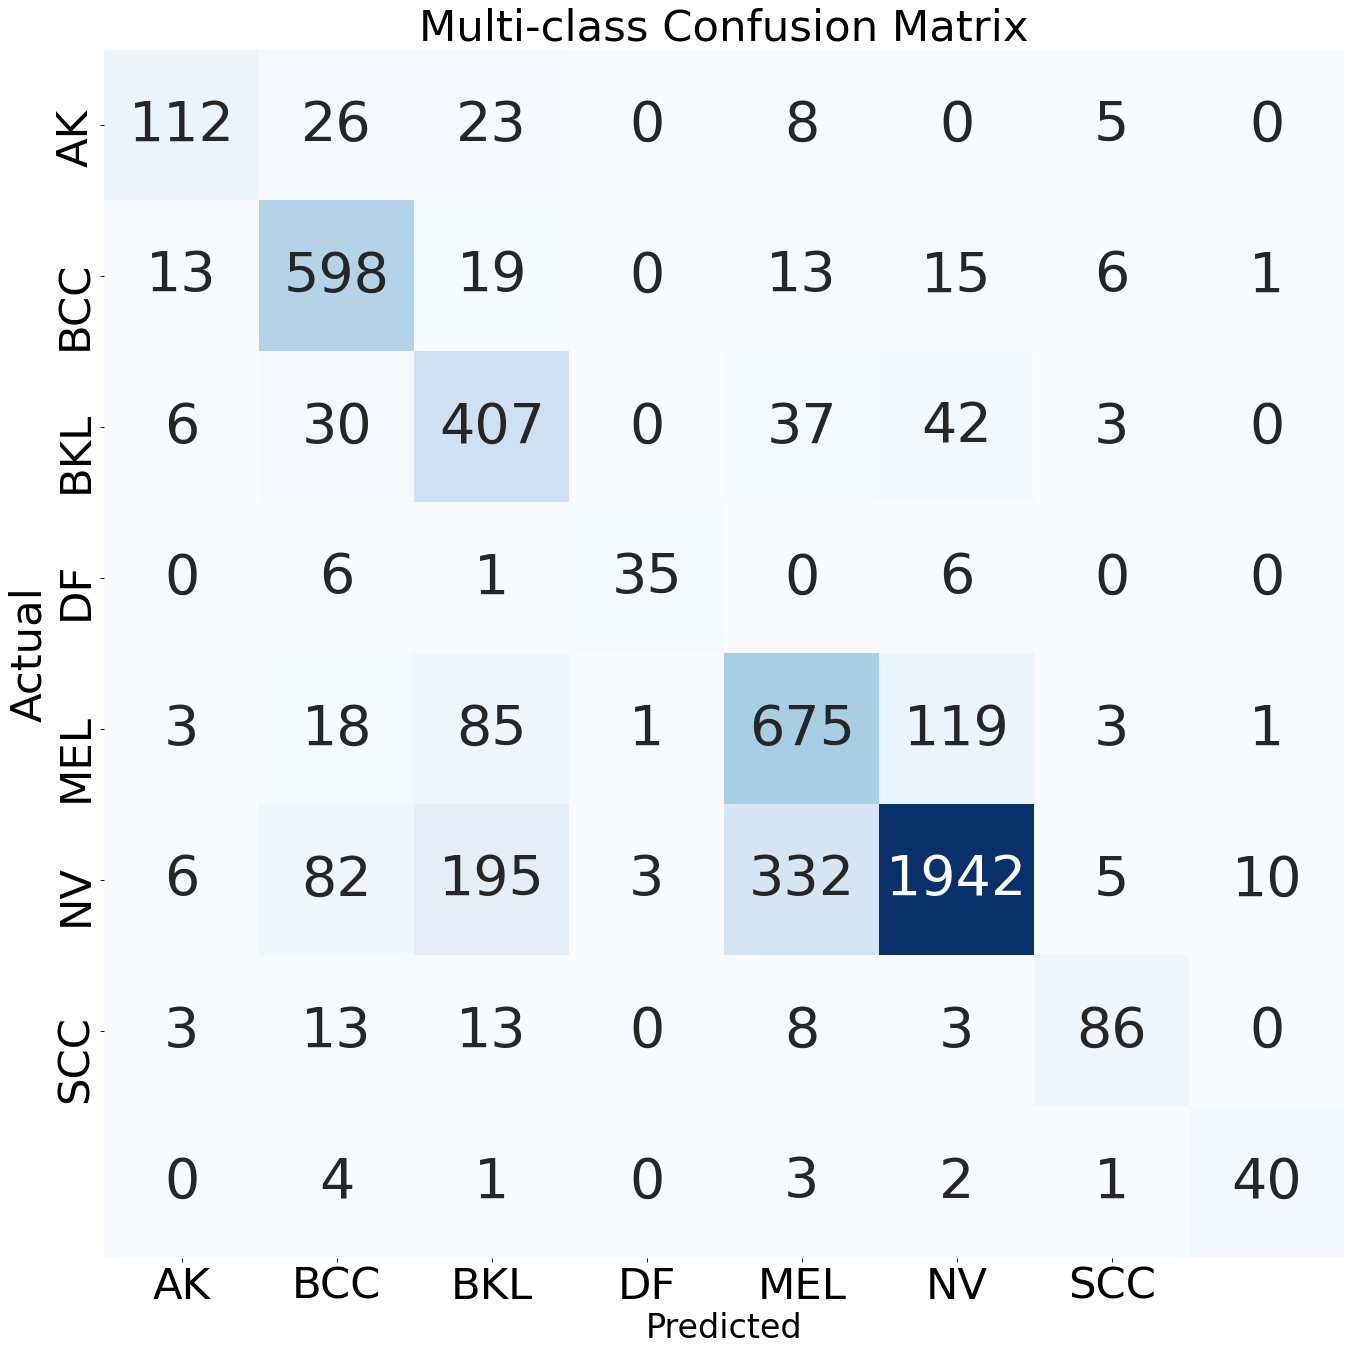

In [120]:
import seaborn as sns
def plot_cm(cm):
    plt.figure(figsize=(20, 20), dpi=80)
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues',annot_kws={"size": 50})
    if len(cm)==2:

        plt.xticks(np.arange(2) + 0.5, ['not_dangerous','dangerous'],fontsize=39)

        plt.yticks(np.arange(2) + 0.5, ['not_dangerous','dangerous'],fontsize=39)
        plt.title("Binary Confusion Matrix",fontsize=39)
    if len(cm)==8:

        plt.xticks(np.arange(7) + 0.5, ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'],fontsize=39)
        plt.yticks(np.arange(7) + 0.5, ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'],fontsize=39)
        plt.title("Multi-class Confusion Matrix",fontsize=39)
    
    
    plt.xlabel("Predicted",fontsize=30)
    
    plt.ylabel("Actual",fontsize=39)
    
    

    plt.show()
plot_cm(mult_c)

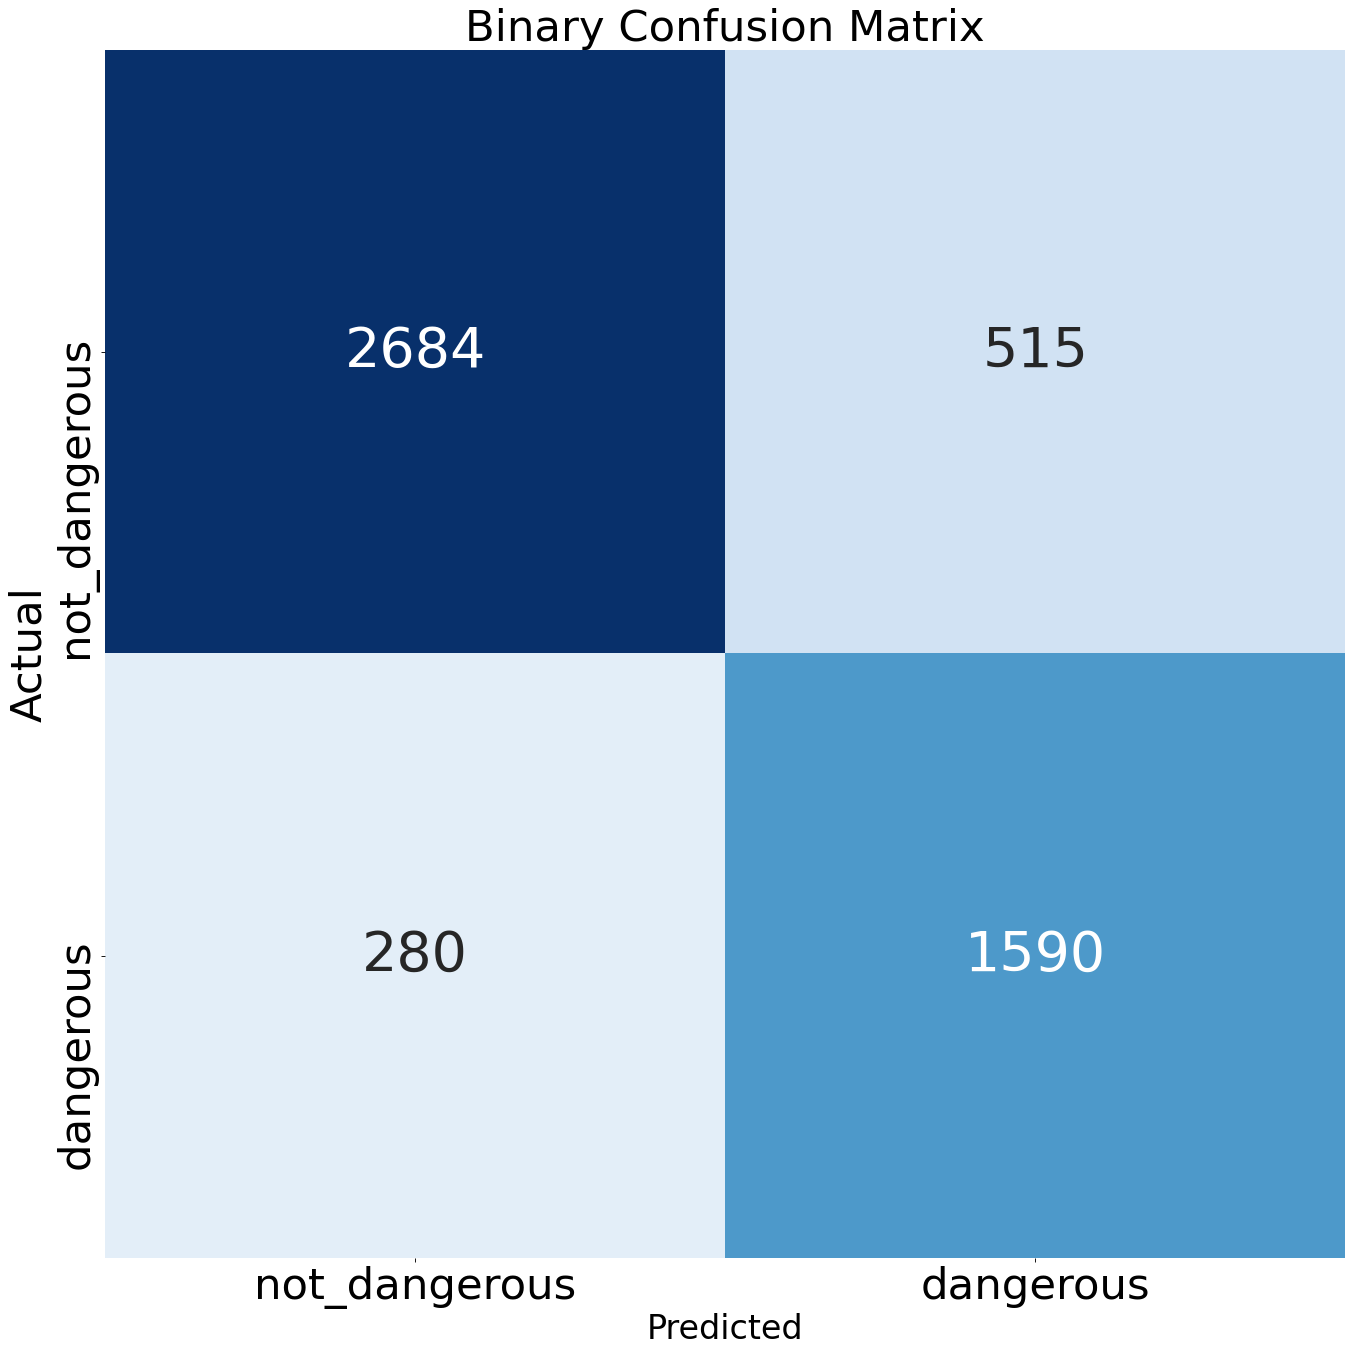

In [121]:
plot_cm(bi)

In [46]:
true_n=[]
true_p=[]
false_p=[]
false_n=[]
for s in [2,3,5,7]:
    for d in [0,1,4,6]:
        true_n.append(mult_c[s][s])
        true_p.append(mult_c[d][d])
        false_p.append(mult_c[d][s])
        false_n.append(mult_c[s][d])
b_c=np.array([[sum(true_n)/4,sum(false_p)],[sum(false_n),sum(true_p)/4]])

In [47]:
b_c

array([[2424.,  280.],
       [ 515., 1471.]])

In [ ]:
plot_cm(b_c)

In [49]:
(2424+1471)/(sum(b_c[0])+sum(b_c[1]))

0.8304904051172708

In [50]:
def true_positve_rate(mult_c):
  for i in testing_set.class_indices.keys():
    ID=testing_set.class_indices[i]
    print('true_positve_rate of '+i,mult_c[ID][ID]/mult_c[ID].sum())




In [51]:
true_positve_rate(mult_c)

true_positve_rate of AK 0.6436781609195402
true_positve_rate of BCC 0.8992481203007519
true_positve_rate of BKL 0.7752380952380953
true_positve_rate of DF 0.7291666666666666
true_positve_rate of MEL 0.7458563535911602
true_positve_rate of NV 0.7541747572815534
true_positve_rate of SCC 0.6825396825396826
true_positve_rate of VASC 0.7843137254901961


In [ ]:
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(7) + 0.5, testing_set.class_indices.keys())
plt.xlabel("Predicted")

plt.yticks(np.arange(7) + 0.5, testing_set.class_indices.keys())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [57]:
from sklearn import metrics
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.71       174
           1       0.77      0.90      0.83       665
           2       0.55      0.78      0.64       525
           3       0.90      0.73      0.80        48
           4       0.63      0.75      0.68       905
           5       0.91      0.75      0.83      2575
           6       0.79      0.68      0.73       126
           7       0.77      0.78      0.78        51

    accuracy                           0.77      5069
   macro avg       0.76      0.75      0.75      5069
weighted avg       0.80      0.77      0.77      5069



In [59]:
y_true

array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

In [68]:
def binary(ts):
  YL=[]
  for i in ts:

    if i in [0,1,4,6]:
      YL.append(1)
    if i in [2,3,5,7]:
      YL.append(0)
      b_t=YL
      return (b_t)

In [69]:
training_set.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [82]:
from numpy import array

In [88]:
YL=[]
for i in y_true:

  if i in [0,1,4,6]:
    YL.append(1)
  if i in [2,3,5,7]:
    YL.append(0)

In [89]:
YP=[]
for i in y_pred:

  if i in [0,1,4,6]:
    YP.append(1)
  if i in [2,3,5,7]:
    YP.append(0)

In [90]:
from sklearn.metrics import confusion_matrix

bi=confusion_matrix(YL, YP, labels=[0, 1])



In [91]:
bi

array([[2684,  515],
       [ 280, 1590]])

In [92]:
from sklearn import metrics
print(metrics.classification_report(YL,YP))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3199
           1       0.76      0.85      0.80      1870

    accuracy                           0.84      5069
   macro avg       0.83      0.84      0.84      5069
weighted avg       0.85      0.84      0.84      5069



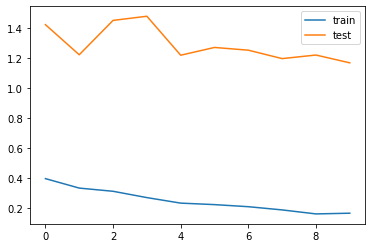

In [ ]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

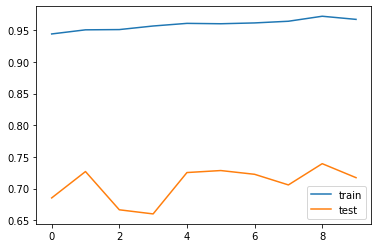

In [ ]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [52]:
model_acc = model.evaluate(testing_set)

159/159 [==============================] - 81s 509ms/step - loss: 1.8083 - accuracy: 0.7684


In [53]:
model_acc

[1.8082863092422485, 0.7683961391448975]

In [ ]:
model=new_model

NameError: ignored